In [28]:
#!pip install import_ipynb &> /dev/null
!pip install -q pycocotools &> /dev/null
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q &> /dev/null
!pip install -q --upgrade keras &> /dev/null

In [29]:
!pip install object_detection_metrics &> /dev/null

In [30]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import keras
import random
import numpy as np
import tensorflow as tf

from keras import optimizers
from keras.optimizers import SGD

import keras_cv
from keras_cv import bounding_box, visualization, losses, layers
from keras_cv.layers import NonMaxSuppression
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import schedules

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import json
import math

In [31]:
#import import_ipynb
from google.colab import drive

drive.mount('/content/gdrive/')

#%cd /content/gdrive/MyDrive/Colab\ Notebooks/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [32]:
print(keras.__version__)
from keras import ops

3.4.1


In [33]:
print(keras_cv.__version__)

0.10.0


In [34]:
import sys
print(sys.version)
print(sys.version_info)
print(tf.__version__)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
2.15.0


In [35]:
ROOT_PATH = '/content/gdrive/MyDrive/BreastCancer/'
IMGS_PATH = ROOT_PATH + 'images/'
MASKS_PATH = ROOT_PATH + 'masks/'
IMG_WIDTH = 224
IMG_HEIGHT = 224
CLASS_NAMES = ['benign', 'malignant']
PADDING = 0.1
BATCH_SIZE = 8
BOUNDING_BOX_FORMAT = 'xyxy'
MAX_DETECTIONS = 1
MAX_DETECTIONS_PER_CLASS = 1
SEED = 666
TEST_SIZE = 0.1
VALID_SIZE = 0.1
EPOCHS = 100
BACKBONE = 'yolo_v8_m_backbone_coco'
DEC_IOU_THRESHOLD = 0.
DEC_CONF_THRESHOLD = 0.25
MALIGNANT = 1
BENIGN = 0
NORMAL = 2
CLASS = None
class_mapping = dict(zip(range(len(CLASS_NAMES)), CLASS_NAMES))

In [36]:
def system_config(SEED_VALUE):

    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')

    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    # Grow the memory usage as the process needs it.
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

    # Enable using cudNN.
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=SEED)

tf.config.run_functions_eagerly(True)

In [37]:
busi_df = pd.read_csv(ROOT_PATH + 'mapping_curated_BUSI_unique_bbox.csv')

In [38]:
def extract_coordinates_and_class(row, multiple_detection=False):
    coords = []
    classes = []

    if BOUNDING_BOX_FORMAT.startswith('rel_'):
        left, top, right, bottom = row.rel_left, row.rel_top, row.rel_right, row.rel_bottom
    else:
        left, top, right, bottom = row.left, row.top, row.right, row.bottom

    if multiple_detection:
        lefts = left.split(',')
        tops = top.split(',')
        rights = right.split(',')
        bottoms = bottom.split(',')
        for i, left in enumerate(lefts):
            top = tops[i]
            right = rights[i]
            bottom = bottoms[i]
            coords.append([int(left), int(top), int(right), int(bottom)])
            classes.append(row['class'])
    else:
        coords.append([int(left), int(top), int(right), int(bottom)])
        classes.append(row['class'])

    return coords, classes

def fill_array_to_dim(arr, shape, value, dim):
    for i in range(np.asarray(arr).shape[0], dim):
        arr = np.append(arr, np.full(shape, -1), axis=0)
    return arr

def create_dataset_from_dataframe(dataframe, multiple_detection=False):
    IMAGE_PATHS = []
    IMAGE_BBOXES = []
    IMAGE_CLASSES = []
    for i, r in dataframe.iterrows():
        class_id = r['class']
        IMAGE_PATHS.append(r.img_path)
        if class_id == 2: #normal
            IMAGE_BBOXES.append(np.full((MAX_DETECTIONS, 4), -1))
            IMAGE_CLASSES.append(np.full((MAX_DETECTIONS), -1))
        else:
            coords, classes = extract_coordinates_and_class(r, multiple_detection)
            coords = fill_array_to_dim(coords, ([1, 4]), -1, MAX_DETECTIONS)
            classes = fill_array_to_dim(classes, (1), -1, MAX_DETECTIONS)
            IMAGE_BBOXES.append(coords)
            IMAGE_CLASSES.append(classes)
    image_path_tensors  = tf.ragged.constant(IMAGE_PATHS)
    bbox_coords_tensors = tf.ragged.constant(IMAGE_BBOXES, dtype=np.float32)
    class_id_tensors    = tf.ragged.constant(IMAGE_CLASSES, dtype=np.float32)

    return tf.data.Dataset.from_tensor_slices((image_path_tensors,
                                           bbox_coords_tensors,
                                           class_id_tensors))

In [39]:
def find_conf_threshold(model, dataset):
    results = []
    confidences = []
    max_f1score = 0.0
    max_f1score_conf = 0.0
    for i in range(0, 100, 5):
        confidence_threshold = i/100.0
        print(confidence_threshold)
        prediction_decoder = CustomNonMaxSuppression(
            bounding_box_format=BOUNDING_BOX_FORMAT,
            from_logits = False,
            iou_threshold=0.15,
            confidence_threshold=confidence_threshold,
            max_detections= MAX_DETECTIONS,
            max_detections_per_class = MAX_DETECTIONS_PER_CLASS
        )
        model.prediction_decoder = prediction_decoder
        tp = 0
        fp = 0
        fn = 0
        for images, y_true in dataset:
            y_pred = model.predict(images, verbose=0)
            num_detections = y_pred['num_detections'][0]
            confidence = y_pred['confidence']
            classes = y_pred['classes']
            partial_tp, partial_fp, partial_fn = confusionMatrix(y_pred, y_true, 0.5)
            tp += partial_tp
            fp += partial_fp
            fn += partial_fn
        f1score_res = f1score(tp, fp, fn)
        if (f1score_res >= max_f1score):
            max_f1score = f1score_res
            max_f1score_conf = confidence_threshold
        confidences.append(confidence_threshold)
        results.append(f1score_res)
    print(f'max f1score {max_f1score:.4f} at {max_f1score_conf}')
    plt.plot([x for x in results])
    plt.title('f1score vs confidence')
    plt.ylabel('f1score')
    plt.xlabel('confidence')
    plt.legend(['f1score'], loc='upper left')
    plt.show()

In [40]:
def load_resize_image(
    image_path,
    resize_image=False,
    size=(IMG_WIDTH, IMG_HEIGHT)):

    image = tf.io.read_file(image_path)
    image = tf.io.decode_image(image, channels=3)
    image.set_shape([None, None, 3])

    og_image_shape = tf.reverse(tf.shape(image)[:2], [0])  # h,w to w,h

    if resize_image:
        image = tf.image.resize(images=image, size=size)
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)
    else:
        image = tf.cast(image, tf.float32)

    return image, og_image_shape

def box_resize(bbox_coords, im_shape, bbox_format, resize=(IMG_WIDTH, IMG_HEIGHT)):
    resize_wh = list(resize)
    ratio_wh  = resize_wh / im_shape
    ratio_multipler = tf.cast(tf.concat([ratio_wh, ratio_wh], axis=-1), tf.float32)

    if (bbox_format.startswith('rel_')):
        to_original_multipler = tf.cast(tf.concat([im_shape, im_shape], axis=-1), tf.float32)
        to_resized_divisor = tf.cast(tf.concat([resize_wh, resize_wh], axis=-1), tf.float32)
        bbox_resize = bbox_coords * to_original_multipler
        bbox_resize = bbox_resize * ratio_multipler
        bbox_resize = bbox_resize / to_resized_divisor
        bbox_resize = tf.clip_by_value(bbox_resize,
                            clip_value_min=[0., 0., 0., 0.],
                            clip_value_max=[1., 1., 1., 1.]
                        )
    else:
        bbox_resize = bbox_coords * ratio_multipler
        bbox_resize = tf.clip_by_value(bbox_resize,
                                   clip_value_min=[0., 0., 0., 0.],
                                   clip_value_max=resize_wh+resize_wh
                                  )
    return bbox_resize

def load_dataset(image_path, bbox_coords, class_ids, resize_data=False):
    # Read Image
    image, og_im_shape = load_resize_image(ROOT_PATH + 'kerascv/' + image_path, resize_image=resize_data)
    bbox_tensor = bbox_coords.to_tensor()
    if resize_data:
        bbox_tensor = box_resize(bbox_tensor, og_im_shape, BOUNDING_BOX_FORMAT)

    bounding_boxes = {
        "classes": tf.cast(class_ids, tf.float32),
        "boxes": bbox_tensor,
    }
    return {"images": tf.cast(image, tf.float32),
            "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    for images, bounding_boxes in inputs:
        nimages = images.get_shape().as_list()[0]
        nrows = 1
        ncols = nimages
        visualization.plot_bounding_box_gallery(
            images,
            value_range=value_range,
            rows=nrows,
            cols=ncols,
            y_true=bounding_boxes,
            scale=2,
            font_scale=0.7,
            bounding_box_format=bounding_box_format,
            class_mapping=class_mapping,
            ground_truth_mapping=None,
        )

In [41]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics =keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format=BOUNDING_BOX_FORMAT,
            evaluate_freq=1e9,
        )
        self.save_path = save_path
        self.best_map = 0.20
        self.best_recall = 0.20

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            #print("************** y true **************")
            #print(y_true)
            #print("************** y pred **************")
            #print(y_pred)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        current_recall = metrics["Recall@[max_detections=1]"]
        # Save the model when mAP improves
        if self.save_path is not None:
            if current_map > self.best_map and epoch>40:
                tf.print(f"\nmAP Improved. Saving model...")
                self.best_map = current_map
                self.model.save_weights(f'{self.save_path}_{epoch}epochs.weights.h5', overwrite=True)
            '''
            if current_recall > self.best_recall:
                tf.print(f"\nmAP Improved. Saving model...")
                self.best_recall = current_recall
                self.model.save_weights(f'{self.save_path}_{epoch}epochs_recall.weights.h5', overwrite=True)
            '''
        return logs

    def on_test_end(self, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            #print("************** y true **************")
            #print(y_true)
            #print("************** y pred **************")
            #print(y_pred)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs


In [42]:
def create_model(from_preset_backbone=BACKBONE,prediction_decoder=None, weights_path=None):
    backbone=keras_cv.models.YOLOV8Backbone.from_preset(from_preset_backbone)
    model = keras_cv.models.YOLOV8Detector(
        num_classes=2,
        bounding_box_format=BOUNDING_BOX_FORMAT,
        backbone=backbone
    )
    if prediction_decoder != None:
        model.prediction_decoder = prediction_decoder
    if weights_path != None:
        model.load_weights(weights_path)

    return model

In [43]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def find_tp(bbox, bboxes, iouThreshold):
    #print(f'bbox: {bbox}')
    for auxbbox in bboxes:
        #print(f'auxbbox: {auxbbox}')
        iou = bb_intersection_over_union(auxbbox, bbox)
        print(f'iou: {iou}')
        if iou >= iouThreshold:
            return True
    return False

def discardBBox(array, discardArray):
    return np.array_equal(array, discardArray)

def confusionMatrix(y_pred, y_true, iouThreshold):
    tp = 0
    fp = 0
    fn = 0
    predBoxesMb = y_pred['boxes']
    trueBoxesMb = y_true['boxes']
    for i, trueBBoxes in enumerate(trueBoxesMb):
        predBBoxes = predBoxesMb[i]
        trueBBoxes = map(np.array, trueBBoxes)
        for predBBox in predBBoxes:
            if not discardBBox(predBBox, np.ones((4)) * -1):
                if find_tp(predBBox, trueBBoxes, iouThreshold):
                    tp += 1
                else:
                    fp += 1
        for trueBBox in trueBBoxes:
            if not discardBBox(trueBBox, np.zeros((4))):
                if not find_tp(trueBBox, predBBoxes, iouThreshold):
                    fn += 1
    return tp, fp, fn

def cls_confusion_matrix(y_pred, y_true):
    tp = 0
    fp = 0
    fn = 0
    tp0 = 0
    fp0 = 0
    fn0 = 0
    tp1 = 0
    fp1 = 0
    fn1 = 0
    preds = y_pred['classes']
    gts = y_true['classes'].numpy().astype('int32')
    for i,gt in enumerate(gts):
        for j,x in enumerate(gt):
            pred = preds[i, j]
            if x==-1 and pred!=-1:
                fp += 1
                if pred==0:
                    fp0 += 1
                elif pred==1:
                    fp1 += 1
            elif x==0:
                if pred==0:
                    tp += 1
                    tp0 += 1
                elif pred==1:
                    fp += 1
                    fp1 += 1
                    fn0 += 1
                elif pred==-1:
                    fn += 1
                    fn0 += 1
            elif x==1:
                if pred==1:
                    tp += 1
                    tp1 += 1
                elif pred==0:
                    fp += 1
                    fp0 += 1
                    fn1 += 1
                elif pred==-1:
                    fn += 1
                    fn1 += 1
    return tp, fp, fn, tp0, fp0, fn0, tp1, fp1, fn1

def f1score(tp, fp, fn):
    print(f'tp, fp, fn: {tp}, {fp}, {fn}')
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1score = (2 * precision * recall) / (precision + recall + 1e-8)
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f1score: {f1score}')
    return f1score

In [44]:
augmenters = tf.keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical", bounding_box_format=BOUNDING_BOX_FORMAT),
        keras_cv.layers.JitteredResize(
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        scale_factor=(0.8, 1.25),
                        bounding_box_format=BOUNDING_BOX_FORMAT
        ),
        keras_cv.layers.RandomSaturation(factor=0.25),
        keras_cv.layers.RandomHue(factor=0.15, value_range=(0., 255.)),
        keras_cv.layers.RandomBrightness(factor=0.15, value_range=(0., 255.)),
    ]
)
'''
noise = keras.layers.GaussianNoise(0.5, seed=SEED)
noise.trainable=True
blur = keras_cv.layers.RandomGaussianBlur(kernel_size = 5, factor = (0.5,0.5))

augmenters = tf.keras.Sequential()
augmenters.add(keras_cv.layers.RandomGaussianBlur(kernel_size = 5, factor = 1.0))
'''

'\nnoise = keras.layers.GaussianNoise(0.5, seed=SEED)\nnoise.trainable=True\nblur = keras_cv.layers.RandomGaussianBlur(kernel_size = 5, factor = (0.5,0.5))\n\naugmenters = tf.keras.Sequential()\naugmenters.add(keras_cv.layers.RandomGaussianBlur(kernel_size = 5, factor = 1.0))\n'

In [45]:
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )

        return ops.where(step > self.total_steps, 0.0, lr)

In [46]:
def get_sgd_with_warmp_up_cosine_decay(num_images):
    total_images = num_images
    total_steps = (total_images // BATCH_SIZE) * EPOCHS
    warmup_steps = int(0.1 * total_steps)
    hold_steps = int(0.45 * total_steps)
    schedule = WarmUpCosineDecay(
        start_lr=0.01,
        target_lr=0.001,
        warmup_steps=warmup_steps,
        total_steps=total_steps,
        hold=hold_steps,
    )
    optimizer = optimizers.SGD(
        global_clipnorm=10.0,
        weight_decay=5e-4,
        learning_rate=schedule,
        momentum=0.9,
    )
    return optimizer


In [47]:
history = [None] * 4

  Fold: 3
  Train: [167, 123, 48]
  Test: [55, 41, 16]
338
Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 143.4150 - val_loss: 527.1075 - val_MaP: 8.3428e-04 - val_MaP@[IoU=50]: 0.0040 - val_MaP@[IoU=75]: 2.4936e-04 - val_MaP@[area=small]: 0.0000e+00 - val_MaP@[area=medium]: 0.0505 - val_MaP@[area=large]: 8.6087e-04 - val_Recall@[max_detections=1]: 0.0037 - val_Recall@[max_detections=10]: 0.0366 - val_Recall@[max_detections=100]: 0.1195 - val_Recall@[area=small]: 0.0000e+00 - val_Recall@[area=medium]: 0.0500 - val_Recall@[area=large]: 0.1250 - MaP: 8.3428e-04 - MaP@[IoU=50]: 0.0040 - MaP@[IoU=75]: 2.4936e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0505 - MaP@[area=large]: 8.6087e-04 - Recall@[max_detections=1]: 0.0037 - Recall@[max_detections=10]: 0.0366 - Recall@[max_detections=100]: 0.1195 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0500 - Recall@[area=large]: 0.1250
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - loss: 134.7618 - val_l

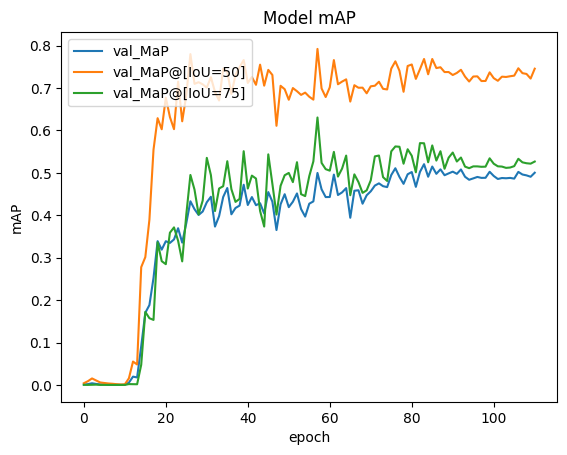

In [ ]:
files = [f'{ROOT_PATH}kerascv/results/{BACKBONE}_fold_0_0.3385.weights.h5',
         f'{ROOT_PATH}kerascv/results/{BACKBONE}_fold_1_0.2762.weights.h5',
         f'{ROOT_PATH}kerascv/results/{BACKBONE}_fold_2_0.2586.weights.h5',
         f'{ROOT_PATH}kerascv/results/{BACKBONE}_fold_3_0.2703.weights.h5']

for fold in range(0, 4):
    X_train = busi_df[busi_df.test_fold != fold]
    X_valid = busi_df[busi_df.test_fold == fold]
    print(f"  Fold: {fold}")
    print(f"  Train: {X_train.groupby(['class'])['class'].count().tolist()}")
    print(f"  Test: {X_valid.groupby(['class'])['class'].count().tolist()}")

    train_data = create_dataset_from_dataframe(X_train)
    val_data = create_dataset_from_dataframe(X_valid)
    train_dataset = train_data.map(lambda pths, box, cls: load_dataset(pths, box, cls, resize_data=True), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(BATCH_SIZE * 4)
    train_dataset = train_dataset.map(augmenters, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.ragged_batch(BATCH_SIZE, drop_remainder=False)
    train_dataset = train_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

    #visualize_dataset(train_dataset, (0, 255), 2, 4, BOUNDING_BOX_FORMAT)

    valid_dataset = val_data.map(lambda pths, box, cls: load_dataset(pths, box, cls, resize_data=True), num_parallel_calls=tf.data.AUTOTUNE)
    valid_dataset = valid_dataset.ragged_batch(BATCH_SIZE, drop_remainder=False)
    valid_dataset = valid_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

    prediction_decoder = keras_cv.layers.NonMaxSuppression(
        bounding_box_format=BOUNDING_BOX_FORMAT,
        from_logits = False,
        iou_threshold=DEC_IOU_THRESHOLD,
        confidence_threshold=DEC_CONF_THRESHOLD,
        max_detections= 1
    )

    epoch = 200
    model = create_model(from_preset_backbone=BACKBONE)
    '''
    model = keras_cv.models.RetinaNet(
        num_classes=2,
        bounding_box_format='xyxy',
        backbone=keras_cv.models.ResNet34Backbone(include_rescaling=True, input_shape=(224, 224, 3)).from_preset("resnet34")
    )
    '''
    #print(model.summary())
    #optimizer = keras.optimizers.Adam(global_clipnorm=10.0)
    print(X_train.shape[0])
    optimizer = get_sgd_with_warmp_up_cosine_decay(X_train.shape[0])
    model.compile(
        optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
    )

    my_callbacks = [#ModelCheckpoint(f'{ROOT_PATH}kerascv/results/{BACKBONE}_best_loss_unique_bbox_fold_{fold}.weights.h5', monitor = 'val_loss',save_best_only = True, save_weights_only = True),
                    EvaluateCOCOMetricsCallback(valid_dataset, f'{ROOT_PATH}kerascv/results/{BACKBONE}_best_unique_bbox_fold_{fold}'),
                    #keras_cv.callbacks.PyCOCOCallback(valid_dataset, bounding_box_format=BOUNDING_BOX_FORMAT),
                    EarlyStopping(monitor='val_loss', patience=20)]

    history[fold] = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        batch_size = BATCH_SIZE,
        epochs=epoch,
        callbacks=[my_callbacks]
    )

    plt.plot(history[fold].history['val_MaP'])
    plt.plot(history[fold].history['val_MaP@[IoU=50]'])
    plt.plot(history[fold].history['val_MaP@[IoU=75]'])
    plt.title('Model mAP')
    plt.ylabel('mAP')
    plt.xlabel('epoch')
    plt.legend(['val_MaP', 'val_MaP@[IoU=50]', 'val_MaP@[IoU=75]'], loc='upper left')
    plt.show()


In [ ]:
pip install pybboxes

In [ ]:
def save_detections(model, dataset, path, crops_path=None):
    for images, bboxes in dataset:
        visualize_detections(model, dataset, (images, bboxes))
        #result = model.predict(images.numpy(), batch_size=BATCH_SIZE)


def visualize_detections(model, dataset, pred_true=None):
    if pred_true==None:
        images, y_true = next(iter(dataset.shuffle(8).take(1)))
    else:
        images, y_true = pred_true
    nimages = images.get_shape().as_list()[0]
    nrows = 1
    ncols = nimages

    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=BOUNDING_BOX_FORMAT,
        y_true=y_true,
        y_pred=y_pred,
        scale=3,
        rows=nrows,
        cols=ncols,
        show=True,
        font_scale=0.5,
        class_mapping=class_mapping,
    )

def eval_model(model, dataset, show_results=False):
    model.compile(
        optimizer=keras.optimizers.SGD(global_clipnorm=10.0), classification_loss="binary_crossentropy", box_loss="ciou"
    )
    if show_results:
        save_detections(model, dataset, path='path', crops_path=None)
    model.evaluate(dataset, batch_size=BATCH_SIZE, callbacks=[EvaluateCOCOMetricsCallback(dataset, None)], return_dict=True)
    #model.evaluate(dataset, batch_size=BATCH_SIZE, callbacks=[keras_cv.callbacks.PyCOCOCallback(dataset, bounding_box_format=BOUNDING_BOX_FORMAT)], return_dict=True)


In [ ]:
from pybboxes import BoundingBox
is_normal = lambda x: (x[0]==-1 and x[1]==-1 and x[2]==-1 and x[3]==-1) or (x[0]==0 and x[1]==0 and x[2]==0 and x[3]==0)
limit_bbox = lambda x: (max(math.floor(x[0]), 0), max(math.floor(x[1]), 0), min(math.ceil(x[2]), 224), min(math.ceil(x[3]), 224))

to_bbox = lambda x: BoundingBox.from_voc(*limit_bbox(x), image_size=(IMG_WIDTH, IMG_HEIGHT), strict=False) if not is_normal(x) else BoundingBox.from_voc(*[-2, -2, -1, -1] , image_size=(IMG_WIDTH, IMG_HEIGHT), strict=False)
iou = lambda x, y: x.iou(y)
def calculate_metrics(model, dataset):
    ious = []
    classes_true = []
    classes_pred = []
    true_bboxes = []
    pred_bboxes = []
    pred = []
    true = []
    for images, y_true in dataset:
        y_pred = model.predict(images, verbose=0)
        true_bbox = [to_bbox(bbox[0]) for bbox in y_true['boxes'].numpy()]
        true_bboxes += true_bbox
        pred += [bbox[0] for bbox in y_pred['boxes']]
        true += [bbox[0] for bbox in y_true['boxes'].numpy()]
        pred_bbox = [to_bbox(bbox[0]) for bbox in y_pred['boxes']]
        pred_bboxes += pred_bbox
        ious += [x.iou(y) for x, y in zip(true_bbox, pred_bbox)]
        classes_true += [x[0] for x in y_true['classes'].numpy().astype(int)]
        classes_pred += [x[0] for x in y_pred['classes']]
    return ious, classes_true, classes_pred, true_bboxes, pred_bboxes, true, pred

In [48]:

#yolo_m
files = [f'{ROOT_PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_0_111epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_1_76epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_2_70epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_3_118epochs.weights.h5']
'''
#yolo_s
files = [f'{ROOT_PATH}kerascv/results/yolo_v8_s_backbone_coco_best_unique_bbox_fold_0_82epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/yolo_v8_s_backbone_coco_best_unique_bbox_fold_1_47epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/yolo_v8_s_backbone_coco_best_unique_bbox_fold_2_92epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/yolo_v8_s_backbone_coco_best_unique_bbox_fold_3_87epochs.weights.h5']'''
'''
#yolo_xs
files = [f'{ROOT_PATH}kerascv/results/yolo_v8_xs_backbone_coco_best_unique_bbox_fold_0_139epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/yolo_v8_xs_backbone_coco_best_unique_bbox_fold_1_120epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/yolo_v8_xs_backbone_coco_best_unique_bbox_fold_2_136epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/yolo_v8_xs_backbone_coco_best_unique_bbox_fold_3_83epochs.weights.h5']'''
'''
#retina_34
files = [f'{ROOT_PATH}kerascv/results/retina34_best_unique_bbox_fold_0_112epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/retina34_best_unique_bbox_fold_1_54epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/retina34_best_unique_bbox_fold_2_81epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/retina34_best_unique_bbox_fold_3_57epochs.weights.h5']'''
'''
#retina18
files = [f'{ROOT_PATH}kerascv/results/retina18_best_unique_bbox_fold_0_49epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/retina18_best_unique_bbox_fold_1_62epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/retina18_best_unique_bbox_fold_2_75epochs.weights.h5',
         f'{ROOT_PATH}kerascv/results/retina18_best_unique_bbox_fold_3_66epochs.weights.h5']'''
ious = []
classes_true = []
classes_pred = []
bboxes_true = []
bboxes_pred = []
true = []
pred = []
format_3f = lambda x: "{0:.3f}".format(x)
for fold in range(0,1):
    prediction_decoder = keras_cv.layers.NonMaxSuppression(
            bounding_box_format=BOUNDING_BOX_FORMAT,
            from_logits = False,
            iou_threshold=1,
            confidence_threshold=0.25,
            max_detections=1
        )
    X_valid = busi_df[(busi_df.test_fold == fold)]
    print(f"  Test: {X_valid.groupby(['class'])['class'].count().tolist()}")
    val_data = create_dataset_from_dataframe(X_valid)
    valid_dataset = val_data.map(lambda pths, box, cls: load_dataset(pths, box, cls, resize_data=True), num_parallel_calls=tf.data.AUTOTUNE)
    valid_dataset = valid_dataset.ragged_batch(BATCH_SIZE, drop_remainder=False)
    valid_dataset = valid_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
    model = create_model(from_preset_backbone=BACKBONE, prediction_decoder = prediction_decoder, weights_path=files[fold])
    '''
    model = keras_cv.models.RetinaNet(
        num_classes=2,
        bounding_box_format='xyxy',
        backbone=keras_cv.models.ResNet34Backbone(include_rescaling=True, input_shape=(224, 224, 3)).from_preset("resnet34")
    )
    model.load_weights(files[fold])
    model.prediction_decoder=prediction_decoder
    '''
    #eval_model(model, valid_dataset, show_results=True)
    visualize_dataset(valid_dataset, (0, 255), 2, 4, BOUNDING_BOX_FORMAT)
    ious_fold, classes_true_fold, classes_pred_fold, bboxes_true_fold, bboxes_pred_fold, true_fold, pred_fold= calculate_metrics(model, valid_dataset)
    ious += ious_fold
    classes_true += classes_true_fold
    classes_pred += classes_pred_fold
    bboxes_true += bboxes_true_fold
    bboxes_pred += bboxes_pred_fold
    true += true_fold
    pred += pred_fold
    print(len(ious_fold))
    print([format_3f(x) for x in ious_fold])
    print(classes_true_fold)
    print(classes_pred_fold)

print(ious)
print(classes_true)
print(classes_pred)
print(bboxes_true)
print(bboxes_pred)
print(true)
print(pred)

In [ ]:
problems = [109, 268, 296]

In [ ]:
for i in range(len(problems)):
    print(classes_true[problems[i]])
    print(bboxes_true[problems[i]])
    print(true[problems[i]])
    print(classes_pred[problems[i]])
    print(bboxes_pred[problems[i]])
    print(pred[problems[i]])
    print('***********')


-1
<[-2 -2 -1 -1] (1x1) | Image: (224x224)>
[0. 0. 0. 0.]
0
<[3 36 64 93] (61x57) | Image: (224x224)>
[ 2.5316238 36.41008   63.761818  93.43244  ]
***********
0
<[5 5 164 110] (159x105) | Image: (224x224)>
[  5.010526    4.7435293 164.16841   110.1553   ]
-1
<[-2 -2 -1 -1] (1x1) | Image: (224x224)>
[-1. -1. -1. -1.]
***********
1
<[2 25 167 147] (165x122) | Image: (224x224)>
[  1.9683657  24.88889   166.52373   147.38127  ]
-1
<[-2 -2 -1 -1] (1x1) | Image: (224x224)>
[-1. -1. -1. -1.]
***********


<ipython-input-35-262b2787fddf>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(data=graph, x='classes', y='ious', palette='pastel', width=0.3)
<ipython-input-35-262b2787fddf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_xticklabels(['Benigno', 'Maligno', 'Normal'], fontsize=12)


[Text(0, 0, 'Benigno'), Text(1, 0, 'Maligno'), Text(2, 0, 'Normal')]

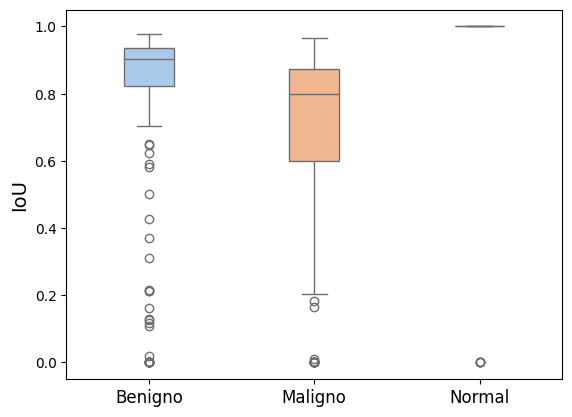

In [ ]:
import seaborn as sns
replace_normal = lambda x: 2 if x==-1 else x
map(replace_normal, classes_true)
graph = {'ious': np.asarray(ious), 'classes': map(replace_normal, classes_true)}
boxplot = sns.boxplot(data=graph, x='classes', y='ious', palette='pastel', width=0.3)
boxplot.set_xlabel('', fontsize=14)
boxplot.set_ylabel('IoU', fontsize=14)

boxplot.set_xticklabels(['Benigno', 'Maligno', 'Normal'], fontsize=12)

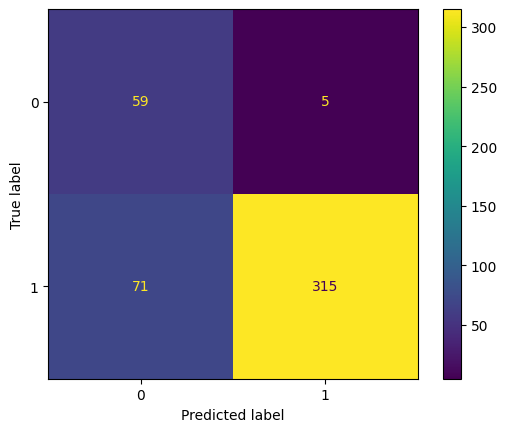

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

detection_pred = [1 if x>=0.5 and y >-1 else (1 if y ==-1 and x<0.5 else 0) for x, y in zip(ious,classes_true)]
detection_true = [1 if x>-1 else 0 for x in classes_true]

ConfusionMatrixDisplay.from_predictions(detection_true, detection_pred)

In [ ]:
classes_true = [1 if x>-1 else 0 for x in classes_true]

In [ ]:
classes_pred = [1 if x>-1 else 0 for x in classes_pred]

In [ ]:
from sklearn.metrics import classification_report

classification_report(classes_true, classes_pred, output_dict=True, zero_division=0.0)

{'0': {'precision': 0.5673076923076923,
  'recall': 0.921875,
  'f1-score': 0.7023809523809524,
  'support': 64},
 '1': {'precision': 0.9855491329479769,
  'recall': 0.883419689119171,
  'f1-score': 0.9316939890710382,
  'support': 386},
 'accuracy': 0.8888888888888888,
 'macro avg': {'precision': 0.7764284126278346,
  'recall': 0.9026473445595855,
  'f1-score': 0.8170374707259953,
  'support': 450},
 'weighted avg': {'precision': 0.926065905834692,
  'recall': 0.8888888888888888,
  'f1-score': 0.8990805794084482,
  'support': 450}}

In [ ]:
[1 if x>=0.5 else 0 for x in ious]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
